# Develop a machine learning model to predict water temperature. The CalCOFI dataset represents the longest (1949-present) and most complete (more than 50,000 sampling stations) time series of oceanographic and larval fish data in the world. It includes abundance data on the larvae of over 250 species of fish; larval length frequency data and egg abundance data on key commercial species; and oceanographic and plankton data. The physical, chemical, and biological data collected at regular time and space intervals quickly became valuable for documenting climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific-warming event in 1957–58 and introduced the term “El Ni˜no” into the scientific literature. Use bottle.csv.Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

the study of the marine environment off the coast of California, the management of its living resources, and monitoring the indicators of El Nino and climate change. CalCOFI conducts quarterly cruises off southern & central California, collecting a suite of hydrographic and biological data on station and underway. Data collected at depths down to 500 m include: temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

In [3]:
def calculate_corr_matrix(df):
    
    column_names = df.columns
    col_len = len(column_names)
    
    matrix = {col:{each:0 for each in df} for col in df}
    
    for i in range(col_len):
        for j in range(i,col_len):
            left = column_names[i]
            right = column_names[j]
            
            left_col_mean = df[left].mean()
            right_col_mean = df[right].mean()
            
            std_dev_left = df[left].std()
            std_dev_right = df[right].std()
            
            covar = ((df[left]-left_col_mean)*(df[right]-right_col_mean)).mean()
            corr = covar/(std_dev_left * std_dev_right) 
            matrix[left][right] = corr
            matrix[right][left] = corr
            
    return matrix

# extracting columns with values above threshold

# def correlated_columns(data,threshold):
#     correlated_columns = set()
#     matrix = pd.DataFrame(calculate_corr_matrix(data))
#     for i in range(len(data.columns)):
#         for j in range(i):
#             if abs(matrix.iloc[i,j]) > threshold:
#                 column_name = matrix.columns[i]
#                 correlated_columns.add(column_name)
#     return correlated_columns


def myScaler(X):
    mean = X.mean()
    std = X.std()
    X = (X-mean)/std
    return X


def time_series_cross_validation(model, X, y, n_splits=5):

    n_samples = X.shape[0]
    fold_size = n_samples // (n_splits + 1)
    mse_scores = []
    
    for i in range(n_splits):
        
        train_end = fold_size * (i + 1)
        X_train, y_train = X[:train_end], y[:train_end]
        X_valid, y_valid = X[train_end:train_end + fold_size], y[train_end:train_end + fold_size]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)

        mse = sum((a-p)**2 for a,p in zip(y_valid,y_pred))/len(y_valid)
        mse_scores.append(mse)
        print(f"Fold {i + 1}: MSE = {mse:.4f}")
        
    print("MSE mean: ",sum(mse_scores)/n_splits)


def MSE(y_valid,y_pred):
    return sum((a-p)**2 for a,p in zip(y_valid,y_pred))/len(y_valid)

In [4]:
class MyLinearRegression:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.W = None

    def fit(self, X, Y):

        n_s, n_f = X.shape
        self.W = np.zeros(n_f)
       
        penalty = self.alpha * np.eye(n_f)
        X_bias = np.hstack((np.ones((n_s, 1)), X))
        penalty = self.alpha * np.eye(X_bias.shape[1])
        penalty[0, 0] = 0 
        self.W = np.linalg.inv(X_bias.T.dot(X_bias) + penalty).dot(X_bias.T).dot(Y)

    def predict(self, X):

        n_s = X.shape[0]
        X_bias = np.hstack((np.ones((n_s, 1)), X))
        return pd.Series(X_bias.dot(self.W))


In [5]:
bottleData = pd.read_csv('bottle.csv',dtype = {47:'str',73:'str'})

In [6]:
bottleCopy = copy.deepcopy(bottleData)

In [7]:
bottleCopy.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(bottleCopy.shape)

(864863, 74)


In [9]:
bottleCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              864863 non-null  int64  
 1   Btl_Cnt              864863 non-null  int64  
 2   Sta_ID               864863 non-null  object 
 3   Depth_ID             864863 non-null  object 
 4   Depthm               864863 non-null  int64  
 5   T_degC               853900 non-null  float64
 6   Salnty               817509 non-null  float64
 7   O2ml_L               696201 non-null  float64
 8   STheta               812174 non-null  float64
 9   O2Sat                661274 non-null  float64
 10  Oxy_µmol/Kg          661268 non-null  float64
 11  BtlNum               118667 non-null  float64
 12  RecInd               864863 non-null  int64  
 13  T_prec               853900 non-null  float64
 14  T_qual               23127 non-null   float64
 15  S_prec           

In [10]:
redundant_columns = ['Cst_Cnt','Btl_Cnt','Depth_ID','T_prec','BtlNum','RecInd','T_qual','S_prec','S_qual','P_qual','O_qual','SThtaq','O2Satq','Chlqua','Phaqua','PO4q','SiO3qu','NO2q','NO3q','NH3q','C14A1p','C14A1q','C14As2','C14A2p','C14A2q','DarkAp','DarkAq','MeanAp','MeanAq','IncTim','R_Depth','R_TEMP','R_POTEMP','R_SALINITY','R_SIGMA','R_SVA','R_DYNHT','R_O2','R_O2Sat','R_SIO3','R_PO4','R_NO3','R_NO2','R_NH4','R_CHLA','R_PHAEO','R_PRES','R_SAMP','DIC1','DIC2','TA1','TA2','pH1','pH2','DIC Quality Comment']
bottleCopy.drop(columns = redundant_columns,inplace = True)

In [11]:
bottleCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Sta_ID       864863 non-null  object 
 1   Depthm       864863 non-null  int64  
 2   T_degC       853900 non-null  float64
 3   Salnty       817509 non-null  float64
 4   O2ml_L       696201 non-null  float64
 5   STheta       812174 non-null  float64
 6   O2Sat        661274 non-null  float64
 7   Oxy_µmol/Kg  661268 non-null  float64
 8   ChlorA       225272 non-null  float64
 9   Phaeop       225271 non-null  float64
 10  PO4uM        413317 non-null  float64
 11  SiO3uM       354091 non-null  float64
 12  NO2uM        337576 non-null  float64
 13  NO3uM        337403 non-null  float64
 14  NH3uM        64962 non-null   float64
 15  C14As1       14432 non-null   float64
 16  DarkAs       22649 non-null   float64
 17  MeanAs       22650 non-null   float64
 18  LightP       18651 non-n

NH3uM,C14As1,DarkAs,MeanAs,LightP have missing values > 7,00,000. Hence dropping them.

In [12]:
missing_val_col = ['NH3uM','C14As1','DarkAs','MeanAs','LightP','O2ml_L','O2Sat']
bottleCopy.drop(columns = missing_val_col, inplace = True)

In [13]:
#Dropping rows where output variable is null
bottleCopy.dropna(subset = ['T_degC'],inplace = True)

## Sta_ID is of line number and Station number

In [14]:
bottleCopy['Sta_ID'] = bottleCopy['Sta_ID'].astype(str)
bottleCopy[['Line_Number', 'Station_Number']] = bottleCopy['Sta_ID'].str.split(expand=True)
bottleCopy['Line_Number'] = pd.to_numeric(bottleCopy['Line_Number'], errors='coerce')
bottleCopy['Station_Number'] = pd.to_numeric(bottleCopy['Station_Number'], errors='coerce')
bottleCopy = bottleCopy.drop('Sta_ID',axis=1)

In [15]:
bottleCopy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 853900 entries, 0 to 864862
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Depthm          853900 non-null  int64  
 1   T_degC          853900 non-null  float64
 2   Salnty          814247 non-null  float64
 3   STheta          812174 non-null  float64
 4   Oxy_µmol/Kg     661268 non-null  float64
 5   ChlorA          222184 non-null  float64
 6   Phaeop          222183 non-null  float64
 7   PO4uM           410803 non-null  float64
 8   SiO3uM          352597 non-null  float64
 9   NO2uM           336242 non-null  float64
 10  NO3uM           335927 non-null  float64
 11  Line_Number     853900 non-null  float64
 12  Station_Number  853900 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 91.2 MB


In [16]:
bottleCopy.describe()

,Depthm,T_degC,Salnty,STheta,Oxy_µmol/Kg,ChlorA,Phaeop,PO4uM,SiO3uM,NO2uM,NO3uM,Line_Number,Station_Number
count,853900.000000,853900.000000,814247.000000,812174.000000,661268.000000,222184.000000,222183.000000,410803.000000,352597.000000,336242.000000,335927.000000,853900.000000,853900.000000
mean,228.503218,10.799677,33.841337,25.819394,148.808694,0.441139,0.194327,1.568797,26.674977,0.042289,17.349753,92.606315,66.636633
std,316.870919,4.243825,0.461636,1.167787,90.187533,1.186601,0.360817,1.036199,27.669554,0.104148,14.582618,22.374389,34.538395
min,0.000000,1.440000,28.431000,20.934000,-0.434900,-0.001000,-3.890000,0.000000,0.000000,0.000000,-0.400000,1.000000,0.000000
25%,48.000000,7.680000,33.489000,24.965000,60.915470,0.050000,0.050000,0.470000,3.200000,0.000000,0.600000,80.000000,45.000000
50%,125.000000,10.060000,33.866000,25.996000,151.064150,0.160000,0.110000,1.580000,18.100000,0.010000,18.200000,90.000000,60.000000
75%,300.000000,13.880000,34.197000,26.646000,240.379600,0.380000,0.230000,2.480000,41.700000,0.030000,30.000000,103.300000,80.000000
max,5351.000000,31.140000,37.034000,250.784000,485.701800,66.110000,65.300000,5.210000,196.000000,8.190000,95.000000,176.700000,531.000000


min value of ChlorA,Phaeop,NO3uM have negative values.

In [17]:
negative_cols = ['ChlorA','Phaeop','NO3uM','Oxy_µmol/Kg']
bottleCopy[negative_cols] = bottleCopy[negative_cols].mask(bottleCopy[negative_cols]<0,0)

In [18]:
bottleCopy.describe().T

,count,mean,std,min,25%,50%,75%,max
Depthm,853900.0,228.503218,316.870919,0.000,48.00000,125.00000,300.0000,5351.0000
T_degC,853900.0,10.799677,4.243825,1.440,7.68000,10.06000,13.8800,31.1400
Salnty,814247.0,33.841337,0.461636,28.431,33.48900,33.86600,34.1970,37.0340
STheta,812174.0,25.819394,1.167787,20.934,24.96500,25.99600,26.6460,250.7840
Oxy_µmol/Kg,661268.0,148.808697,90.187529,0.000,60.91547,151.06415,240.3796,485.7018
ChlorA,222184.0,0.441139,1.186601,0.000,0.05000,0.16000,0.3800,66.1100
Phaeop,222183.0,0.194388,0.360582,0.000,0.05000,0.11000,0.2300,65.3000
PO4uM,410803.0,1.568797,1.036199,0.000,0.47000,1.58000,2.4800,5.2100
SiO3uM,352597.0,26.674977,27.669554,0.000,3.20000,18.10000,41.7000,196.0000
NO2uM,336242.0,0.042289,0.104148,0.000,0.00000,0.01000,0.0300,8.1900


<Axes: >

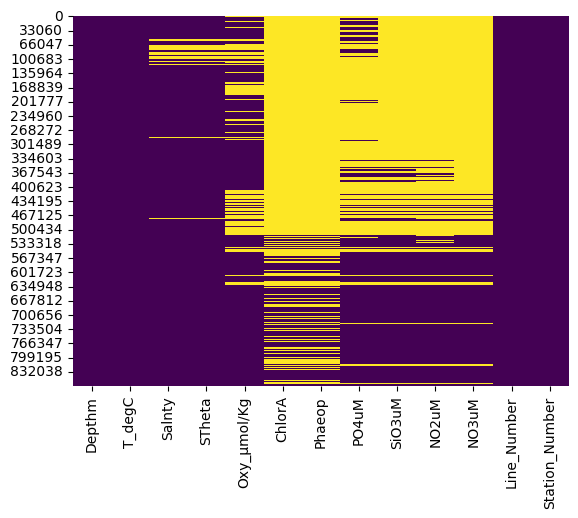

In [19]:
sns.heatmap(bottleCopy.isnull(), cbar=False, cmap='viridis')

In [20]:
prev_var = bottleCopy.var()
prev_var

Depthm            100407.179613
T_degC                18.010048
Salnty                 0.213108
STheta                 1.363727
Oxy_µmol/Kg         8133.790409
ChlorA                 1.408022
Phaeop                 0.130020
PO4uM                  1.073707
SiO3uM               765.604235
NO2uM                  0.010847
NO3uM                212.652627
Line_Number          500.613289
Station_Number      1192.900722
dtype: float64

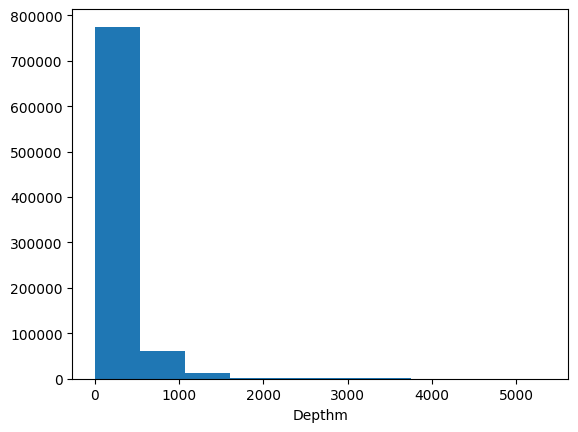

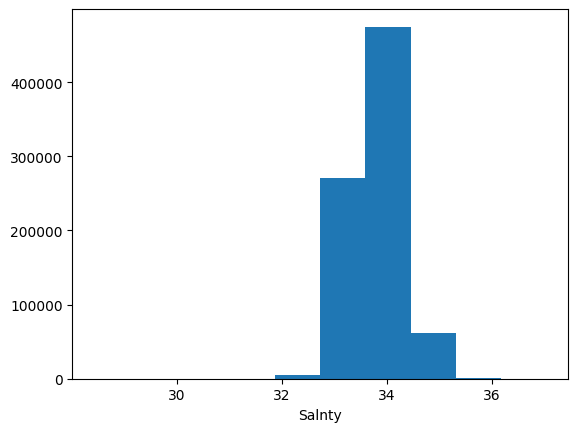

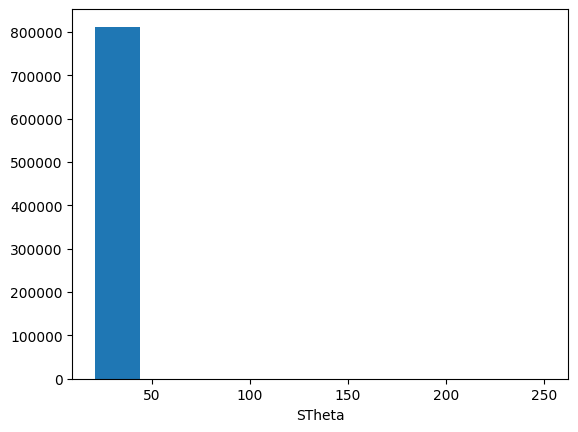

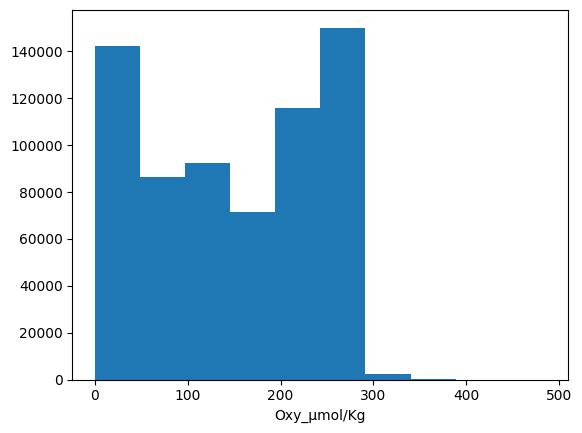

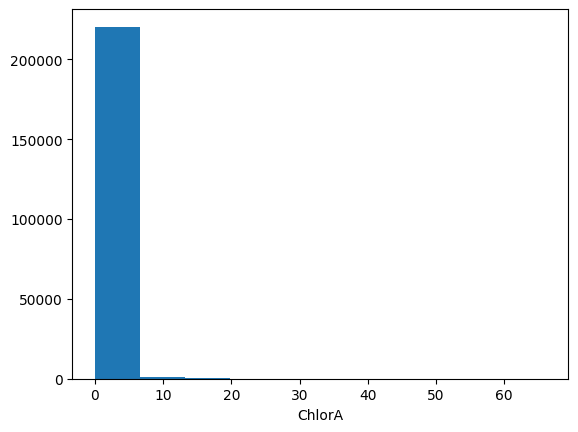

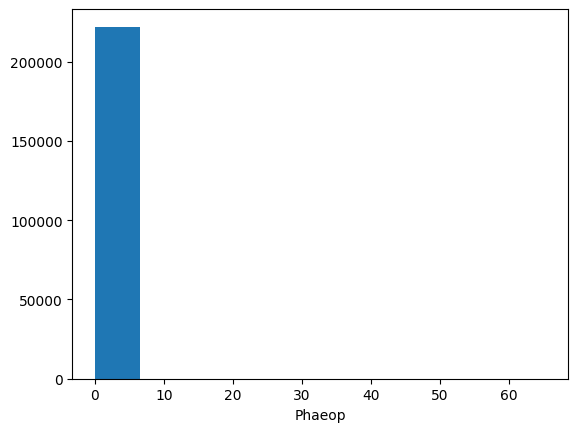

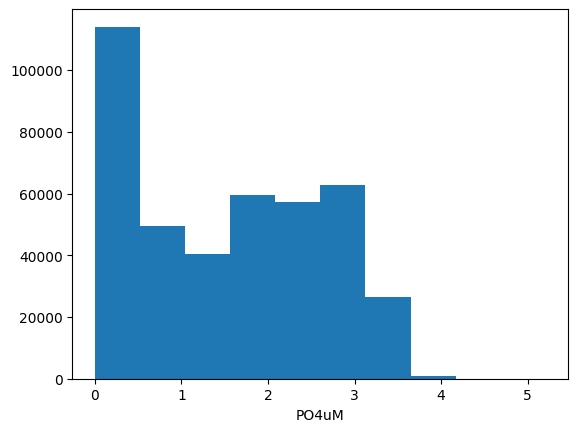

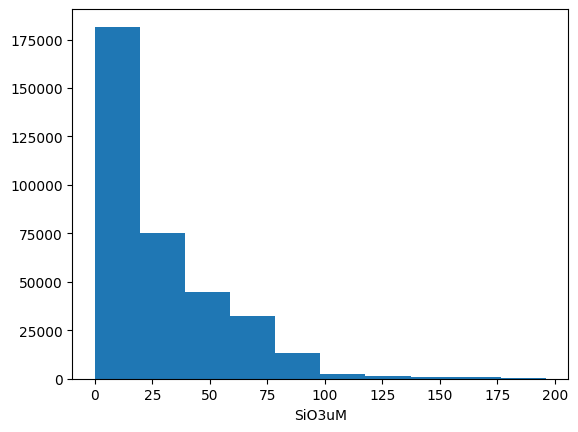

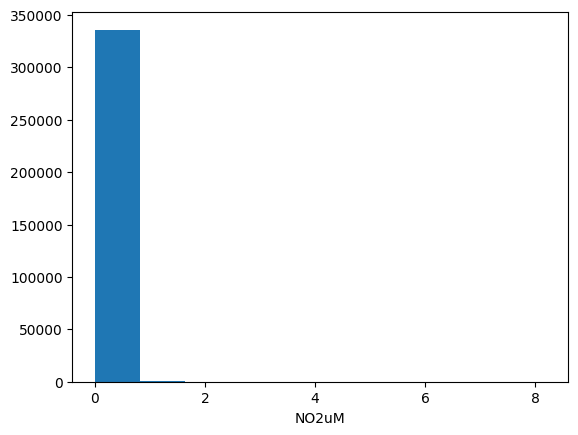

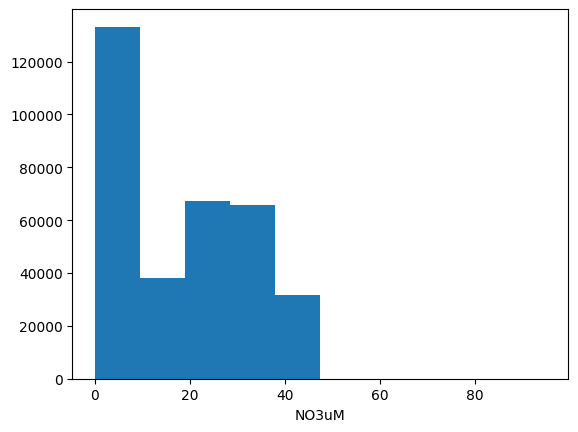

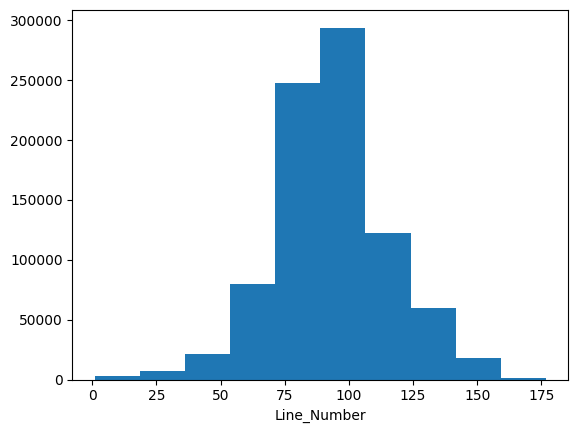

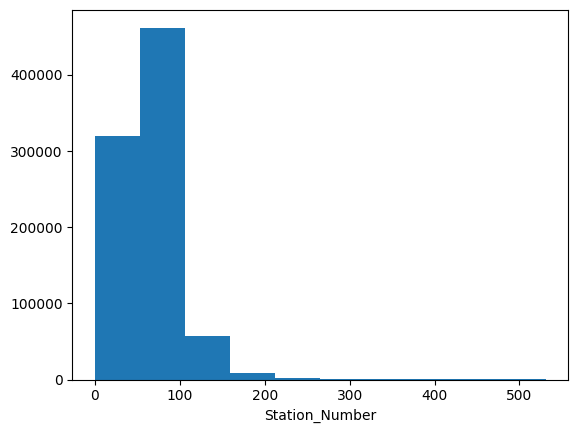

In [24]:
#Distribution analysis before imputation
for i in bottleCopy.columns:
    if i != "T_degC":
        plt.hist(bottleCopy[i])
        # Add labels and title
        plt.xlabel(i) 
        plt.show()

# Data is skewed , could have used transformation like Box-Cox

In [25]:
# #Boxplot
# for i in bottleCopy.columns:
#     plt.boxplot(bottleCopy[i])
#     # Add labels and title
#     plt.xlabel(i) 
#     plt.show()

In [23]:
bottleCopy_median = bottleCopy.fillna(bottleCopy.median())
bottleCopy_mean = bottleCopy.fillna(bottleCopy.mean())

In [31]:

ori_var = bottleCopy.var()
mean_var = bottleCopy_mean.var()
print(ori_var)
print(mean_var)

Depthm            100407.179613
T_degC                18.010048
Salnty                 0.213108
STheta                 1.363727
Oxy_µmol/Kg         8133.790409
ChlorA                 1.408022
Phaeop                 0.130020
PO4uM                  1.073707
SiO3uM               765.604235
NO2uM                  0.010847
NO3uM                212.652627
Line_Number          500.613289
Station_Number      1192.900722
dtype: float64
Depthm            100407.179613
T_degC                18.010048
Salnty                 0.203211
STheta                 1.297088
Oxy_µmol/Kg         6298.879823
ChlorA                 0.366365
Phaeop                 0.033831
PO4uM                  0.516550
SiO3uM               316.136909
NO2uM                  0.004271
NO3uM                 83.658075
Line_Number          500.613289
Station_Number      1192.900722
dtype: float64


In [33]:
(ori_var) - (mean_var)

Depthm               0.000000
T_degC               0.000000
Salnty               0.009896
STheta               0.066639
Oxy_µmol/Kg       1834.910585
ChlorA               1.041657
Phaeop               0.096189
PO4uM                0.557158
SiO3uM             449.467326
NO2uM                0.006576
NO3uM              128.994552
Line_Number          0.000000
Station_Number       0.000000
dtype: float64

In [30]:
ori_var = bottleCopy.var()
median_var = bottleCopy_median.var()
print(ori_var)
print(median_var)

Depthm            100407.179613
T_degC                18.010048
Salnty                 0.213108
STheta                 1.363727
Oxy_µmol/Kg         8133.790409
ChlorA                 1.408022
Phaeop                 0.130020
PO4uM                  1.073707
SiO3uM               765.604235
NO2uM                  0.010847
NO3uM                212.652627
Line_Number          500.613289
Station_Number      1192.900722
dtype: float64
Depthm            100407.179613
T_degC                18.010048
Salnty                 0.203238
STheta                 1.298537
Oxy_µmol/Kg         6299.768533
ChlorA                 0.381580
Phaeop                 0.035202
PO4uM                  0.516581
SiO3uM               333.961983
NO2uM                  0.004520
NO3uM                 83.830589
Line_Number          500.613289
Station_Number      1192.900722
dtype: float64


In [34]:
(ori_var) - (median_var)

Depthm               0.000000
T_degC               0.000000
Salnty               0.009869
STheta               0.065189
Oxy_µmol/Kg       1834.021875
ChlorA               1.026442
Phaeop               0.094818
PO4uM                0.557126
SiO3uM             431.642252
NO2uM                0.006327
NO3uM              128.822038
Line_Number          0.000000
Station_Number       0.000000
dtype: float64

In [27]:
# (median_var) - (mean_var)
# The output is explaining using median is slighly worse than mean.

Depthm             0.000000
T_degC             0.000000
Salnty             0.000027
STheta             0.001450
Oxy_µmol/Kg        0.888710
ChlorA             0.015215
Phaeop             0.001371
PO4uM              0.000031
SiO3uM            17.825074
NO2uM              0.000249
NO3uM              0.172514
Line_Number        0.000000
Station_Number     0.000000
dtype: float64

In [ ]:
# Univariate analysis
for i in bottleCopy.columns:
    if i != "T_degC":
        plt.scatter(x=bottleCopy[i], y=bottleCopy['T_degC'])
        
        # Add labels and title
        plt.xlabel(i)
        plt.ylabel('Temperature (°C)')  
        plt.show()

In [ ]:
# Distribution of data
for i in bottleCopy.columns:
    bottleCopy[i].hist(bins=50)
    plt.xlabel(i)
    #sns.histplot(new_df[i], bins=50, kde=True)
    plt.show()

In [230]:
#final decision on imputation 
bottleCopy.fillna(bottleCopy.mean(), inplace=True,axis = 0)

In [ ]:
bottleCopy.info()

In [ ]:
#correlation matrix with output variable T_degC
plt.figure(figsize=(15,15))
print(sns.heatmap(pd.DataFrame(calculate_corr_matrix(bottleCopy.select_dtypes(include = "number"))),annot = True,cmap='coolwarm', linewidths=0.5))

In [ ]:
step_size = 1000
bottleCopy_downsampled = bottleCopy.iloc[::step_size, :]

plt.figure(figsize=(12, 6))
plt.plot(bottleCopy_downsampled.index, bottleCopy_downsampled['T_degC'], color='blue')
plt.xlabel("index")
plt.ylabel("T_degC")
plt.show()

In [ ]:
X = bottleCopy.drop(columns = ["T_degC"])
y = bottleCopy['T_degC']
X.columns

In [235]:
X = myScaler(X)

In [267]:
def train_test_split_custom(data, target, test_size=0.2):
    mask = np.random.rand(len(data)) < (1 - test_size)
    return data[mask], data[~mask], target[mask], target[~mask]


In [237]:
def polynomial_features(X, degree):
    # Ensure X is a 2D array
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, np.newaxis]  # Convert to 2D if X is 1D

    # Generate polynomial features
    poly_features = []
    for d in range(1, degree + 1):
        poly_features.append(X ** d)

    return np.concatenate(poly_features, axis=1)


In [320]:
X_train,X_test,y_train,y_test = train_test_split_custom(X,y,test_size = 0.3)

In [321]:
mlr = MyLinearRegression(alpha = 0.01)

#Linear regression

In [ ]:
#Validation on train data using Linear Regression
time_series_cross_validation(mlr, X_train, y_train, n_splits=5)

In [ ]:
#Validation on test data using Linear Regression
time_series_cross_validation(mlr, X_test, y_test, n_splits=5)

In [ ]:
mlr.fit(X_train,y_train)
y_pred = mlr.predict(X_test)
print("T_degC mean: ",bottleCopy['T_degC'].mean())
print("Y_test mean: ",y_test.mean())
print("Algorithm average prediction: ",y_pred.sum()/len(y_pred))

In [ ]:
plt.figure(figsize=(12, 6))
plt.ylim(-20,y_pred.max())
plt.plot(y_pred.index, y_pred, color='blue')
plt.xlabel("index")
plt.ylabel("y_pred")
plt.show()

In [ ]:
print("mean squared error on custom function:",MSE(y_test,y_pred))

# Polynomial regression of degree 2

In [338]:
X_train_poly2 = polynomial_features(X_train,2)
X_test_poly2 = polynomial_features(X_test,2)

In [339]:
polymlr2 = MyLinearRegression()
polymlr2.fit(X_train_poly2,y_train)

In [ ]:
y_poly_pred2 = polymlr2.predict(X_test_poly2)
print("mean squared error on custom function with degree 2 polynomial:",MSE(y_test,y_poly_pred2))

# Polynomial regression of degree 3

In [341]:
X_train_poly3 = polynomial_features(X_train,3)
X_test_poly3 = polynomial_features(X_test,3)

In [342]:
polymlr3 = MyLinearRegression()
polymlr3.fit(X_train_poly3,y_train)

In [ ]:
y_poly_pred3 = polymlr3.predict(X_test_poly3)
print("mean squared error on custom function with degree 5 polynomial:",MSE(y_test,y_poly_pred3))

# If null values are dropped completely

In [310]:
bottled = copy.deepcopy(bottleData)
redundant_columns = ['Cst_Cnt','Btl_Cnt','Depth_ID','BtlNum','RecInd','T_qual','S_prec','S_qual','P_qual','O_qual','SThtaq','O2Satq','Chlqua','Phaqua','PO4q','SiO3qu','NO2q','NO3q','NH3q','C14A1p','C14A1q','C14As2','C14A2p','C14A2q','DarkAp','DarkAq','MeanAp','MeanAq','IncTim','R_Depth','R_TEMP','R_POTEMP','R_SALINITY','R_SIGMA','R_SVA','R_DYNHT','R_O2','R_O2Sat','R_SIO3','R_PO4','R_NO3','R_NO2','R_NH4','R_CHLA','R_PHAEO','R_PRES','R_SAMP','DIC1','DIC2','TA1','TA2','pH1','pH2','DIC Quality Comment']
bottled.drop(columns = redundant_columns,inplace = True)

In [311]:
missing_val_col = ['NH3uM','C14As1','DarkAs','MeanAs','LightP','O2ml_L','O2Sat']
bottled.drop(columns = missing_val_col, inplace = True)

In [312]:
#Dropping rows where output variable is null
bottled.dropna(subset = ['T_degC'],inplace = True)

In [ ]:
bottled.info()

In [314]:
bottled.dropna(inplace = True)

In [ ]:
bottled.info()

In [316]:
X_train_bottled,X_test_bottled,y_train_bottled,y_test_bottled = train_test_split_custom(X,y,test_size = 0.3)

In [317]:
model = MyLinearRegression()
model.fit(X_train_bottled,y_train_bottled)

In [318]:
y_pred_bottle = model.predict(X_test_bottled)

In [ ]:
print(y_pred_bottle.mean())
print(y_test.mean())